# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Nonlinear Ops --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for **VTI anisotropic variable density visco- pseudo- acoustics** using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are two notebooks in this series:

##### 1. Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Nonlinear and Linearized Ops
- Implement the nonlinear modeling operations. 
- [ssa_11_vti_implementation.ipynb](ssa_11_vti_implementation.ipynb)

##### 2. Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [ssa_12_vti_correctness.ipynb](ssa_12_vti_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for isotropic and TTI anisotropy ([README.md](README.md)).

Below we introduce the *skew self adjoint* form of the scalar VTI anisotropic variable density visco- acoustic wave equation with a simple form of dissipation only Q attenuation. This dissipation only (no dispersion) attenuation term $\left (\frac{\displaystyle \omega}{Q}\ \partial_t\ u \right)$ is an approximation of a [Maxwell Body](https://en.wikipedia.org/wiki/Maxwell_material) -- that is to say viscoelasticity approximated with a spring and dashpot in series. In practice this approach for attenuating outgoing waves is very similar to the Cerjan style damping in absorbing boundaries used elsewhere in Devito ([References](#nl_refs)). 

The derivation of the attenuation model is not in scope for this tutorial, but one important point is that the physics in the absorbing boundary region and the interior of the model are *unified*, allowing the same modeling equations to be used everywhere, with physical Q values in the interior tapering to non-physical small Q at the boundaries to attenuate outgoing waves. 

# FIXME

## Outline 
1. Define symbols [[link]](#nl_symbols) 
2. Introduce the SSA wave equation [[link]](#nl_we) 
3. Show generation of skew symmetric derivatives and prove correctness with unit test [[link]](#nl_ssa_derivs) 
4. Derive the time update equation used to implement the nonlinear forward modeling operator [[link]](#nl_time_update) 
5. Create the Devito grid and model fields [[link]](#nl_grid_and_model) 
6. Define a function to implement the attenuation profile ($\omega\ /\ Q$) [[link]](#nl_attenuation) 

6. Implement and run the nonlinear forward operator [[link]](#ln_nonlinear_operator) 
7. Implement and run the Jacobian forward operator [[link]](#ln_linearized_forward) 
8. Implement and run the Jacobian adjoint operator [[link]](#ln_linearized_adjoint) 


7. Create the Devito operator [[link]](#nl_build_operator) 
8. Run the Devito operator [[link]](#nl_run_operator) 
9. Plot the resulting wavefields [[link]](#nl_plot_wavefield) 
10. References [[link]](#refs) 

<a id="nl_symbols"></a>
## Table of symbols

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
| :---         | :---              | :--- |
| $\omega_c = 2 \pi f_c$ | center angular frequency | constant |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $u(t,x,y,z)$ | Pressure wavefield | function of time and space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $f(x,y,z)$ | $V_s$ approximation defined: $f = 1 - \frac{\displaystyle V_s^2}{\displaystyle V_p^2}$ | function of space |
| $\epsilon(x,y,z)$ | Thomsen's weak anisotropy $\epsilon$  | function of space |
| $\delta(x,y,z)$ | Thomsen's weak anisotropy $\delta$  | function of space |
| $\tilde{\eta}(x,y,z)$ | Defined: $\tilde{\eta} = \sqrt{\frac{\displaystyle 2(\epsilon - \delta)}{\displaystyle f + 2\epsilon}}$ | function of space, note: $\sqrt{1 - \tilde{\eta}^2} = \frac{\displaystyle f + 2\delta}{\displaystyle f + 2\epsilon}$ |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $v(x,y,z)$ | Total P wave velocity ($v_0+\delta v$) | function of space |
| $v_0(x,y,z)$ | Background P wave velocity    | function of space |
| $\delta v(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u(t,x,y,z)$ | Total pressure wavefield ($u_0+\delta u$)| function of time and space |
| $u_0(t,x,y,z)$ | Background pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ |  
| $q(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta v$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta v \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta v$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ | 

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}\ u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}\ u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}\ u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

<a id="nl_we"></a>
## SSA variable density visco- acoustic wave equation

Our skew self adjoint wave equation has two coupled equations for quasi-P state variable $p$ and quasi-shear state variable $m$, and is written:

$$
\begin{aligned}
\frac{b}{m^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ p + \partial_{tt}\ p \right) =\  
    & \overleftarrow{\partial_x}\left[ b\ \bigl(1 + 2\epsilon\bigr)\ 
          \overrightarrow{\partial_x}\ p \right] + 
      \overleftarrow{\partial_y}\left[b\ \bigl(1 + 2\epsilon\bigr)\ 
          \overrightarrow{\partial_y}\ p \right] + \\[5pt]
    & \overleftarrow{\partial_z}\left[b\ \bigl(1 - f\tilde{\eta}^2\bigr) 
          \overrightarrow{\partial_z}\ p \right] + 
      \overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
          \overrightarrow{\partial_z}\ m \right] + q_p \\[15pt]
%     
\frac{b}{m^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ m + \partial_{tt}\ m \right) =\  
    & \overleftarrow{\partial_x}\left[b\ \bigl(1 - f\bigr)\ 
          \overrightarrow{\partial_x}\ m \right] + 
      \overleftarrow{\partial_y}\left[b\ \bigl(1 - f\bigr)\ 
          \overrightarrow{\partial_y}\ m \right] + \\[5pt]
    & \overleftarrow{\partial_z}\left[b\ \bigl(1 - f + f\tilde{\eta}^2\bigr)\ 
          \overrightarrow{\partial_z}\ m \right] + 
      \overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
          \overrightarrow{\partial_z}\ p \right] + q_m \\[15pt]
\end{aligned}
$$

#### Coupling between quasi-P and quasi-S state variables

You will note that the two equations are coupled only via vertical derivatives and the two terms:
 - $\overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
          \overrightarrow{\partial_z}\ m \right]$ for quasi-P
           
 - $\overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
          \overrightarrow{\partial_z}\ p \right]$ for quasi-S
          
This means there are *zero horizontal cross terms* between the quasi-P and quasi-S state variables.

We will drop the quasi-S source $q_m$ in further exposition as we will only inject into the quasi-P wavefield.

#### Use for nonlinear and linearized operations

As discussed in the previous isotropic notebooks, this energy conserving skew self adjoint form allows using the same equations for all nonlinear and linearized operations required for quasi- Newton optimization. Some other widely utilized non energy conserving formulations (not referenced here directly) can provide unstable linearized adjoints, and thus unstable gradients for updating anisotropy parameters.  

## Solve for the quasi-P time update equation

#### 1. Temporal numerical derivatives, sorted into useful form
$$
\begin{aligned}
\overleftarrow{\partial_{t}}\ p &= \frac{\displaystyle p(t) - \
    p(t-\Delta_t)}{\displaystyle \Delta_t}\\[10pt]
% 
p(t+\Delta_t)\ &= \Delta_t^2\ \partial_{tt}\ p + 2\ p(t) - p(t-\Delta_t)
\end{aligned}
$$

#### 2. Solve the quasi-P wave equation for $\partial_{tt}\ p$

$$
\begin{aligned}
\partial_{tt}\ p =\ 
    & \frac{m^2}{b}\ \biggl\{ 
      \overleftarrow{\partial_x}\left[b\ \bigl(1 + 2\epsilon\bigr)\ 
          \overrightarrow{\partial_x}\ p \right] + 
      \overleftarrow{\partial_y}\left[b\ \bigl(1 + 2\epsilon\bigr)\ 
          \overrightarrow{\partial_y}\ p \right] + \\[5pt]
    & \quad \quad\ 
      \overleftarrow{\partial_z}\left[b\ \bigl(1 - f\tilde{\eta}^2\bigr) 
          \overrightarrow{\partial_z}\ p \right] + 
      \overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
          \overrightarrow{\partial_z}\ m \right] + q_p \biggl\}\ - 
          \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ p
\end{aligned}
$$

#### 3. Plug in $\overleftarrow{\partial_t} p$ and $\partial_{tt}\ p$ into quasi-P time update equation 

$$
\begin{aligned}
p(t+\Delta_t) =\  
    & \frac{\Delta_t^2\ m^2}{b} \biggl\{ 
          \overleftarrow{\partial_x}\left[b\ \bigl(1 + 2\epsilon\bigr)\ 
              \overrightarrow{\partial_x}\ p \right] + 
          \overleftarrow{\partial_y}\left[b\ \bigl(1 + 2\epsilon\bigr)\ 
              \overrightarrow{\partial_y}\ p \right] + \\[5pt]
    & \quad \quad \quad\ 
          \overleftarrow{\partial_z}\left[b\ \bigl(1 - f\tilde{\eta}^2\bigr) 
              \overrightarrow{\partial_z}\ p \right] + 
          \overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
              \overrightarrow{\partial_z}\ m \right] + q_p 
    \biggr\} \\[5pt]
    & \quad \quad \quad\ 
        - \Delta_t^2 \frac{\omega_c}{Q} \left( \frac{\displaystyle p(t) - p(t-\Delta_t)}
            {\displaystyle \Delta_t}\ \right) + 2\ p(t) - p(t-\Delta_t)\\[15pt]
% 
 =\ & \frac{\Delta_t^2\ m^2}{b} \biggl\{ \texttt{Space Part} \biggr\} 
        + \bigl( 2 -  \Delta_t \frac{\omega_c}{Q} \bigr)\ p(t) 
        + \bigl( \Delta_t \frac{\omega_c}{Q} - 1 \bigr)\ p(t-\Delta_t)
\end{aligned}
$$


## Solve for the quasi-M time update equation

#### 1. Temporal numerical derivatives, sorted into useful form
$$
\begin{aligned}
\overleftarrow{\partial_{t}}\ m &= \frac{\displaystyle m(t) - \
    m(t-\Delta_t)}{\displaystyle \Delta_t}\\[10pt]
% 
m(t+\Delta_t)\ &= \Delta_t^2\ \partial_{tt}\ m + 2\ p(t) - m(t-\Delta_t)
\end{aligned}
$$

#### 2. Solve the quasi-S wave equation for $\partial_{tt}\ m$

$$
\begin{aligned}
\partial_{tt}\ m =\ 
    & \frac{m^2}{b}\ \biggl\{ 
      \overleftarrow{\partial_x}\left[b\ \bigl(1 - f\bigr)\ 
          \overrightarrow{\partial_x}\ m \right] + 
      \overleftarrow{\partial_y}\left[b\ \bigl(1 - f\bigr)\ 
          \overrightarrow{\partial_y}\ m \right] + \\[5pt]
    & \quad \quad\ 
      \overleftarrow{\partial_z}\left[b\ \bigl(1 - f + f\tilde{\eta}^2\bigr) 
          \overrightarrow{\partial_z}\ m \right] + 
      \overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
          \overrightarrow{\partial_z}\ p \right] \biggl\}\ - 
          \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ m
\end{aligned}
$$

#### 3. Plug in $\overleftarrow{\partial_t} m$ and $\partial_{tt}\ m$ into quasi-S time update equation 

$$
\begin{aligned}
m(t+\Delta_t) =\  
    & \frac{\Delta_t^2\ m^2}{b} \biggl\{ 
          \overleftarrow{\partial_x}\left[b\ \bigl(1 - f\bigr)\ 
              \overrightarrow{\partial_x}\ m \right] + 
          \overleftarrow{\partial_y}\left[b\ \bigl(1 - f\bigr)\ 
              \overrightarrow{\partial_y}\ m \right] + \\[5pt]
    & \quad \quad \quad\ 
          \overleftarrow{\partial_z}\left[b\ \bigl(1 - f + f\tilde{\eta}^2\bigr) 
              \overrightarrow{\partial_z}\ m \right] + 
          \overleftarrow{\partial_z}\left[b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ 
              \overrightarrow{\partial_z}\ p \right]  
    \biggr\} \\[5pt]
    & \quad \quad \quad\ 
        - \Delta_t^2 \frac{\omega_c}{Q} \left( \frac{\displaystyle p(t) - p(t-\Delta_t)}
            {\displaystyle \Delta_t}\ \right) + 2\ p(t) - p(t-\Delta_t)\\[15pt]
% 
 =\ & \frac{\Delta_t^2\ m^2}{b} \biggl\{ \texttt{Space Part} \biggr\}
        + \bigl( 2 -  \Delta_t \frac{\omega_c}{Q} \bigr)\ m(t) 
        + \bigl( \Delta_t \frac{\omega_c}{Q} - 1 \bigr)\ m(t-\Delta_t)
\end{aligned}
$$


## Imports 

We have grouped all imports used in this notebook here for consistency.

In [19]:
import numpy as np
from sympy import sqrt
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import (compute_critical_dt,
                                                setup_w_over_q)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# We define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'
# configuration['log-level'] = 'INFO'

## Instantiate the Devito grid for a two dimensional problem

We define the grid the same as in the previous notebook outlining implementation for the nonlinear forward.

In [20]:
# Define dimensions for the interior of the model
nx,nz = 751,751
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])
dtype = np.float32

# Define dimensions for the model padded with absorbing boundaries
npad = 100          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx + 2 * npad, nz + 2 * npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (751, 751)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (7500.0, 7500.0)

shape_pad;        [951 951]
origin_pad;       (-1000.0, -1000.0)
extent_pad;       (9500.0, 9500.0)

grid.shape;       (951, 951)
grid.extent;      (9500.0, 9500.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define model parameters

Define the dimensions and coordinates for the model. The computational domain of the model is surrounded by an *absorbing boundary region* where we implement boundary conditions to eliminate outgoing waves. We define the sizes for the interior of the model ```nx``` and ```nz```, the width of the absorbing boundary region ```npad```, and the sizes for the entire model padded with absorbing boundaries become ```nxpad = nx + 2*npad``` and ```nzpad = nz + 2*npad```.

We also create ```Functions``` to represent buoyancy, velocity, and Thomsen's ansisotropy parameters $\epsilon$ and $\delta$.

We also instantiate the $\omega_c / Q$ attenuation model ```wOverQ```.

In [21]:
# We create buoyancy, and both background and perturbation variables for 
# each model parameter (velocity, epsilon, eta).
space_order = 8

b    = Function(name='b', grid=grid, space_order=space_order)
vel0 = Function(name='vel0', grid=grid, space_order=space_order)
eps0 = Function(name='eps0', grid=grid, space_order=space_order)
eta0 = Function(name='eta0', grid=grid, space_order=space_order)
dvel = Function(name='dvel', grid=grid, space_order=space_order)
deps = Function(name='deps', grid=grid, space_order=space_order)
deta = Function(name='deta', grid=grid, space_order=space_order)

f       = 0.85
vel_val = 1.5
eps_val = 0.2
del_val = 0.1
eta_val = np.sqrt(2 * (eps_val - del_val) / (f + 2 * eps_val)) 

# Background models are constant
vel0.data[:] = vel_val
eps0.data[:] = eps_val
eta0.data[:] = eta_val
b.data[:,:] = 1.0 / 1.0

# Perturbation to velocity
size = 20
x0 = shape_pad[0]//2
z0 = shape_pad[1]//2
dvel.data[:] = 0.0
dvel.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Shift perturbation to epsilon up in Z
x0 = shape_pad[0]//2
z0 = 1*shape_pad[1]//3
deps.data[:] = 0.0
deps.data[x0-size:x0+size, z0-size:z0+size] = 0.01

# Shift perturbation to epsilon down in Z
x0 = shape_pad[0]//2
z0 = 2*shape_pad[1]//3
deta.data[:] = 0.0
deta.data[x0-size:x0+size, z0-size:z0+size] = 0.02

# Initialize the attenuation profile for Q=100 model
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 1000.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

Allocating memory for vel0(967, 967)
Allocating memory for eps0(967, 967)
Allocating memory for eta0(967, 967)
Allocating memory for b(967, 967)
Allocating memory for dvel(967, 967)
Allocating memory for deps(967, 967)
Allocating memory for deta(967, 967)
Operator `WOverQ_Operator` generated in 0.07 s
  * lowering.Expressions: 0.03 s (49.5 %)
  * lowering.IET: 0.03 s (49.5 %)
     * specializing.IET: 0.02 s (33.0 %)
Flops reduction after symbolic optimization: [10 --> 10]
Allocating memory for wOverQ(967, 967)
Operator `WOverQ_Operator` fetched `/tmp/devito-jitcache-uid5138/17ea3bd726ab9f0f46ff688178e918268b5b7b43.c` in 0.09 s from jit-cache
Operator `WOverQ_Operator` run in 0.01 s
* section0<951,951> with OI=2.50 computed in 0.01 s [4.77 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


## Define the simulation time range and the acquisition geometry 

#### Simulation time range: 

In this notebook we run 3 seconds of simulation using the sample rate related to the CFL condition as implemented in ```examples/seismic/skew_self_adjoint/utils.py```. 

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

#### Acquisition geometry: 

**source**:
- X coordinate: left sode of model
- Z coordinate: middle of model
- We use a 10 Hz center frequency [RickerSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L280) wavelet source as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: right side of model
- Z coordinate: vertical line in model
- We use a vertical line of [Receivers](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80) as defined with a ```PointSource``` in ```examples/seismic/source.py```

In [22]:
t0 = 0.0     # Simulation time start
tn = 3000.0  # Simulation time end (1 second = 1000 msec)
dt = 1.0
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

# Source at 1/4 X, 1/2 Z, Ricker with 10 Hz center frequency
src_nl = RickerSource(name='src_nl', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src_nl.coordinates.data[0,0] = dx * 1 * nx//4
src_nl.coordinates.data[0,1] = dz * shape[1]//2

# Receivers at 3/4 X, line in Z
rec_nl = Receiver(name='rec_nl', grid=grid, npoint=nz, time_range=time_range)
rec_nl.coordinates.data[:,0] = dx * 3 * nx//4
rec_nl.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src_nl.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src_nl.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec_nl.coordinates.data[:,0]), np.max(rec_nl.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec_nl.coordinates.data[:,1]), np.max(rec_nl.coordinates.data[:,1])))

Allocating memory for src_nl(3001, 1)
Allocating memory for src_nl_coords(1, 2)
Allocating memory for rec_nl_coords(751, 2)


Time min, max, dt, num;   0.000000 3000.000000   1.000000 3001
time_range;  TimeAxis: start=0, stop=3000, step=1, num=3001
src_coordinate  X;           +1877.0000
src_coordinate  Z;           +3755.0000
rec_coordinates X min/max;   +5632.0000   +5632.0000
rec_coordinates Z min/max;      +0.0000   +7500.0000


## Plot the model 

We plot the following ```Functions```:
- Background Velocity, velocity perturbation
- Background epsilon, epsilon perturbation
- Background delta, delta perturbation
- Background Density, Q Model

Each subplot also shows:
- The location of the absorbing boundary as a dotted line
- The source location as a red star
- The line of receivers as a black vertical line

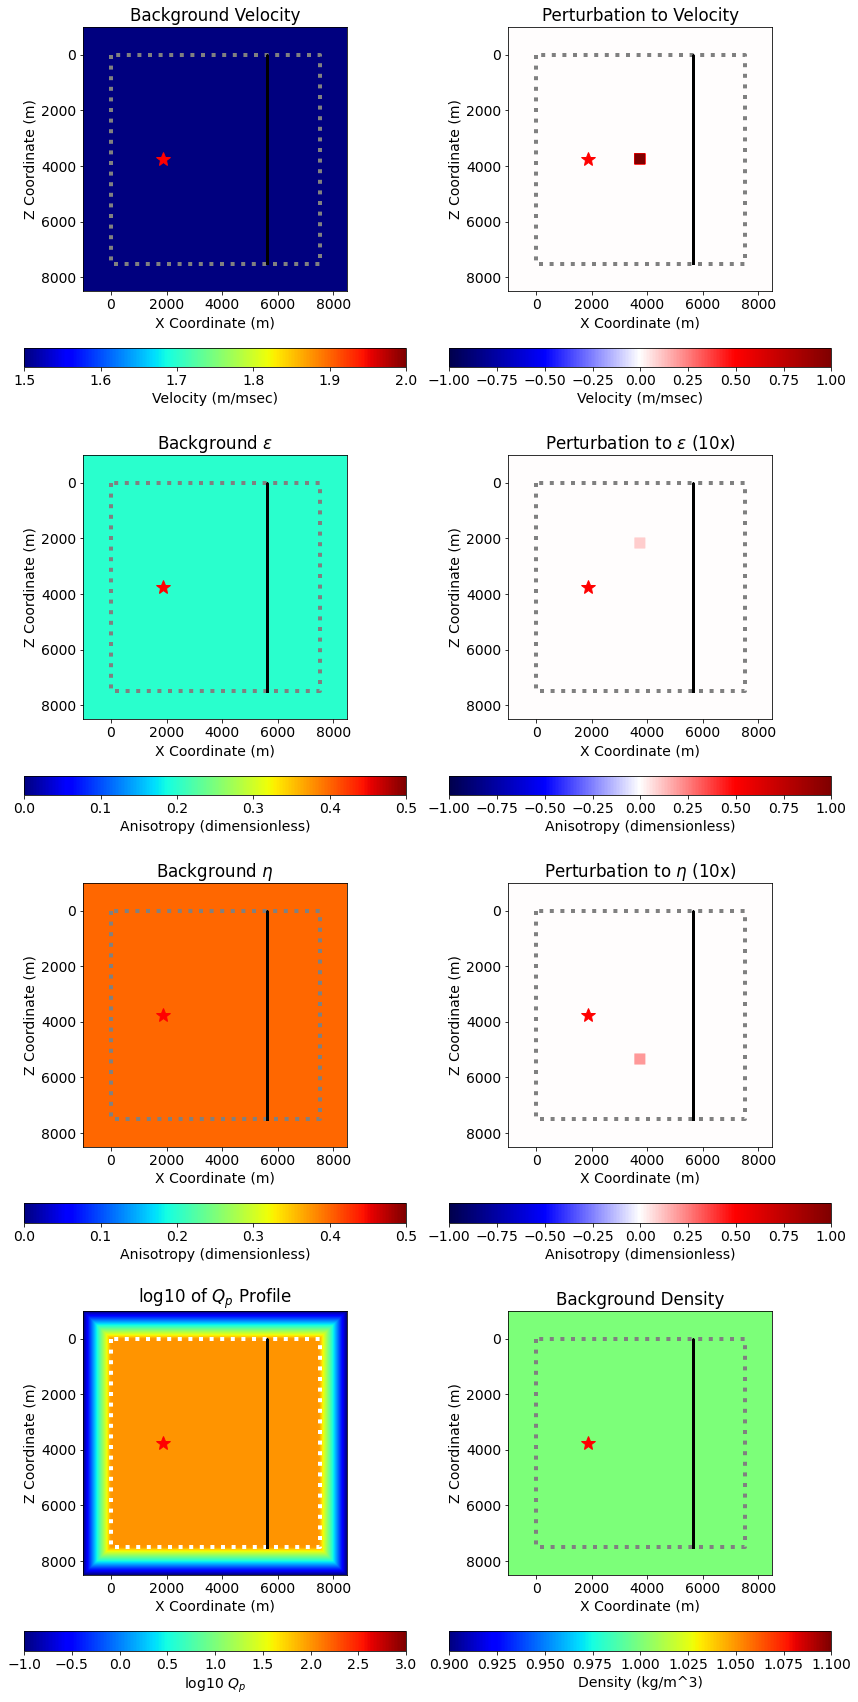

In [23]:
#NBVAL_INGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

vmin, vmax = 1.5, 2.0   # velocity min/max
amin, amax = 0.0, 0.5   # anisotropy min/max
bmin, bmax = 0.9, 1.1   # buoyancy min/max
dmin, dmax = -1, +1     # perturbation min/max

q = w / wOverQ.data[:]

x1 = 0.0
x2 = dx * nx
z1 = 0.0
z2 = dz * nz
abcX = [x1,x1,x2,x2,x1]
abcZ = [z1,z2,z2,z1,z1]

plt.figure(figsize=(12,24))

# Background model parameters
plt.subplot(4, 2, 1)
plt.imshow(np.transpose(vel0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Velocity")

plt.subplot(4, 2, 3)
plt.imshow(np.transpose(eps0.data), cmap=cm.jet, 
           vmin=amin, vmax=amax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background $\epsilon$")

plt.subplot(4, 2, 5)
plt.imshow(np.transpose(eta0.data), cmap=cm.jet, 
           vmin=amin, vmax=amax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background $\eta$")

plt.subplot(4, 2, 7)
plt.imshow(np.transpose(np.log10(q.data)), cmap=cm.jet,
           vmin=np.log10(qmin), vmax=np.log10(qmax), extent=plt_extent)
plt.plot(abcX, abcZ, 'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='log10 $Q_p$')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q_p$ Profile")

# Perturbation parameters
plt.subplot(4, 2, 2)
plt.imshow(np.transpose(dvel.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to Velocity")

plt.subplot(4, 2, 4)
plt.imshow(np.transpose(10 * deps.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to $\epsilon$ (10x)")

plt.subplot(4, 2, 6)
plt.imshow(np.transpose(10 * deta.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to $\eta$ (10x)")

plt.subplot(4, 2, 8)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Density (kg/m^3)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Density")

plt.tight_layout()
None

## Define pressure wavefields

We need two state variables for quasi-P and quasi-M, and two wavefields for nonlinear and linearized operations. See the 2nd notebook in the isotropic series for more information. 

For this example workflow we will require saving all time steps from the nonlinear forward operator for use in the Jacobian operators. There are other ways to implement this requirement, including checkpointing, but that is way outside the scope of this illustrative workflow.  

In [24]:
# Define the TimeFunctions for nonlinear and Jacobian operations
nt = time_range.num
p0 = TimeFunction(name="p0", grid=grid, time_order=2, space_order=space_order, save=nt)
m0 = TimeFunction(name="m0", grid=grid, time_order=2, space_order=space_order, save=nt)
dp = TimeFunction(name="dp", grid=grid, time_order=2, space_order=space_order, save=nt)
dm = TimeFunction(name="dm", grid=grid, time_order=2, space_order=space_order, save=nt)

# Get the dimensions for t, x, z 
t,x,z = p0.dimensions

## Notation and functions for spatial derivative operators

We now introduce a new notation for shifted spatial derivative operators. We use this notation because both VTI and TTI systems can be expressed with the same equations, after small changes to these operators. 

For TTI systems these operators are linear combination of spatial derivatives and rotations. For VTI systems these operators are simply the pure orthogonal derivative operators $\partial_x$, $\partial_y$, and $\partial_z$.

$$
\begin{aligned}
g_1 &         \rightarrow \partial_x \quad \texttt{evaluated at} \quad (x+\frac{\Delta_x}{2},y,z)\\[5pt]
\tilde{g}_1 & \rightarrow \partial_x \quad \texttt{evaluated at} \quad (x-\frac{\Delta_x}{2},y,z)\\[5pt]
g_2 &         \rightarrow \partial_y \quad \texttt{evaluated at} \quad (x,y+\frac{\Delta_y}{2},z)\\[5pt]
\tilde{g}_2 & \rightarrow \partial_y \quad \texttt{evaluated at} \quad (x,y-\frac{\Delta_y}{2},z)\\[5pt]
g_3 &         \rightarrow \partial_z \quad \texttt{evaluated at} \quad (x,y,z+\frac{\Delta_z}{2})\\[5pt]
\tilde{g}_3 & \rightarrow \partial_z \quad \texttt{evaluated at} \quad (x,y,z-\frac{\Delta_z}{2})\\[5pt]
\end{aligned}
$$

Recall that $g_1$ and $\tilde{g_1}$ will by *skew symmetric* (also called anti- symmetric), meaning that for random $x_1$ and $x_2$:

$$
\begin{aligned}
x_2 \cdot g_1 x_1 \approx - x_1 \cdot \tilde{g}_1 x_2
\end{aligned}
$$

We implement these new spatial derivative operators in the cell immediately below.

In [25]:
def g1(field):
    return field.dx(x0=x+x.spacing/2)

def g1_tilde(field):
    return field.dx(x0=x-x.spacing/2)

def g2(field):
    return field.dy(x0=y+y.spacing/2)

def g2_tilde(field):
    return field.dy(x0=y-y.spacing/2)

def g3(field):
    return field.dz(x0=z+z.spacing/2)

def g3_tilde(field):
    return field.dz(x0=z-z.spacing/2)

## Implement and run the nonlinear operator

We next transcribe the time update expression for the nonlinear operator above into a Devito ```Eq```. Then we add the source injection and receiver extraction and build an ```Operator``` that will generate the c code for performing the modeling.

We copy the time update expression from above, but omit the source term $q$ because for the nonlinear operator we explicitly inject the source using ```src_term```. 

$$
\begin{aligned}
& p(t+\Delta_t) = \\[5pt]
&\quad \frac{\Delta_t^2\ m^2}{b}
    \biggl\{ 
          \tilde{g}_1\left[b\ \bigl(1 + 2\epsilon\bigr)\        g_1\ p \right] + 
          \tilde{g}_2\left[b\ \bigl(1 + 2\epsilon\bigr)\        g_2\ p \right] + 
          \tilde{g}_3\left[b\ \bigl(1 - f\tilde{\eta}^2\bigr) g_3\ p + 
              b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\    g_3\ m \right] 
    \biggr\} \\[5pt]
    & \quad \quad \quad\ 
        + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ p
        + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ p(t-\Delta_t) \\[15pt]
%         
& m(t+\Delta_t) = \\[5pt]
&\quad \frac{\Delta_t^2\ m^2}{b}
    \biggl\{ 
          \tilde{g}_1\left[b\ \bigl(1 - f\bigr)\                    g_1\ m \right] + 
          \tilde{g}_2\left[b\ \bigl(1 - f\bigr)\                    g_2\ m \right] + 
          \tilde{g}_3\left[b\ \bigl(1 - f + f\tilde{\eta}^2\bigr) g_3\ m + 
              b\ f\tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\        g_3\ p \right]  
    \biggr\} \\[5pt]
    & \quad \quad \quad\ 
        + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ m
        + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ m(t-\Delta_t)
\end{aligned}
$$

## Source injection and receiver extraction for nonlinear forward operator

Source injection and receiver extraction follow the implementation shown in the first notebook, please refer there for more information. 

In [26]:
#NBVAL_IGNORE_OUTPUT

# Time update equation for quasi-P state variable p
update_p_nl = t.spacing**2 * vel0**2 / b * \
    (g1_tilde(b * (1 + 2 * eps0) * g1(p0)) + 
     g3_tilde(b * (1 - f * eta0**2) * g3(p0) + 
              b * (f * eta0 * sqrt(1 - eta0**2) * g3(m0)))) + \
    (2 - t.spacing * wOverQ) * p0 + \
    (t.spacing * wOverQ - 1) * p0.backward

# Time update equation for quasi-S state variable m
update_m_nl = t.spacing**2 * vel0**2 / b * \
    (g1_tilde(b * (1 - f) * g1(p0)) + 
     g3_tilde(b * (1 - f + f * eta0**2) * g3(p0) + 
              b * (f * eta0 * sqrt(1 - eta0**2) * g3(m0)))) + \
    (2 - t.spacing * wOverQ) * m0 + \
    (t.spacing * wOverQ - 1) * m0.backward

stencil_p_nl = Eq(p0.forward, update_p_nl)
stencil_m_nl = Eq(m0.forward, update_m_nl)

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Source injection and Receiver extraction
src_term_nl = src_nl.inject(field=p0.forward, expr=src_nl * t.spacing**2 * vel0**2 / b)
rec_term_nl = rec_nl.interpolate(expr=p0.forward)

# Instantiate and run the operator for the nonlinear forward
op_nl = Operator([stencil_p_nl, stencil_m_nl, src_term_nl, rec_term_nl], subs=spacing_map)
# print(op_nl)

p0.data[:] = 0
m0.data[:] = 0
op_nl.apply()

pmin,pmax = np.min(p0.data), np.max(p0.data)
mmin,mmax = np.min(m0.data), np.max(m0.data)
print("")
print("P min/max; %+12.6f %+12.6f" % (pmin, pmax))
print("M min/max; %+12.6f %+12.6f" % (mmin, mmax))

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 1.0}


Operator `Kernel` generated in 2.75 s
  * lowering.Expressions: 1.49 s (54.4 %)
  * lowering.Clusters: 0.81 s (29.6 %)
Flops reduction after symbolic optimization: [1050 --> 199]
Allocating memory for p0(3001, 967, 967)
Allocating memory for m0(3001, 967, 967)
Allocating memory for rec_nl(3001, 751)


gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable --fast-math -shared -fopenmp /tmp/devito-jitcache-uid5138/ebdb09f28f066fd013d50ecd5f9cd41f79828a35.c -lm -o /tmp/devito-jitcache-uid5138/ebdb09f28f066fd013d50ecd5f9cd41f79828a35.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid5138/ebdb09f28f066fd013d50ecd5f9cd41f79828a35.c` in 1.08 s with `GNUCompiler`
Operator `Kernel` run in 11.95 s
Global performance indicators
  * Achieved 0.23 FD-GPts/s
Local performance indicators
  * section0<951,958> with OI=0.38 computed in 0.01 s [0.55 GFlops/s]
  * section1<<2999,958,958>,<2999,951,951>> with OI=2.22 computed in 11.45 s [46.60 GFlops/s, 0.48 GPts/s]
  * section2<<2999,1>,<2999,1>,<2999,1>,<2999,1>,<2999,1>> with OI=3.85 computed in 0.29 s [0.01 GFlops/s, 0.01 GPts/s]
  * section3<<2999,751>,<2999,751>,<2999,751>,<2999,751>,<2999,751>,<2999,751>> with OI=4.84 computed in 0.21 s [0.64 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}



P min/max;   -13.606087   +24.882811
M min/max;   -23.151718   +22.985579


## Plot the nonlinear forward wavefields

Below we show the nonlinear wavefield $p$ at 4 different time steps showing 
1. 0.5 seconds
1. 1.0 seconds
1. 1.5 seconds
1. 2.0 seconds


amax nl;     2.488281


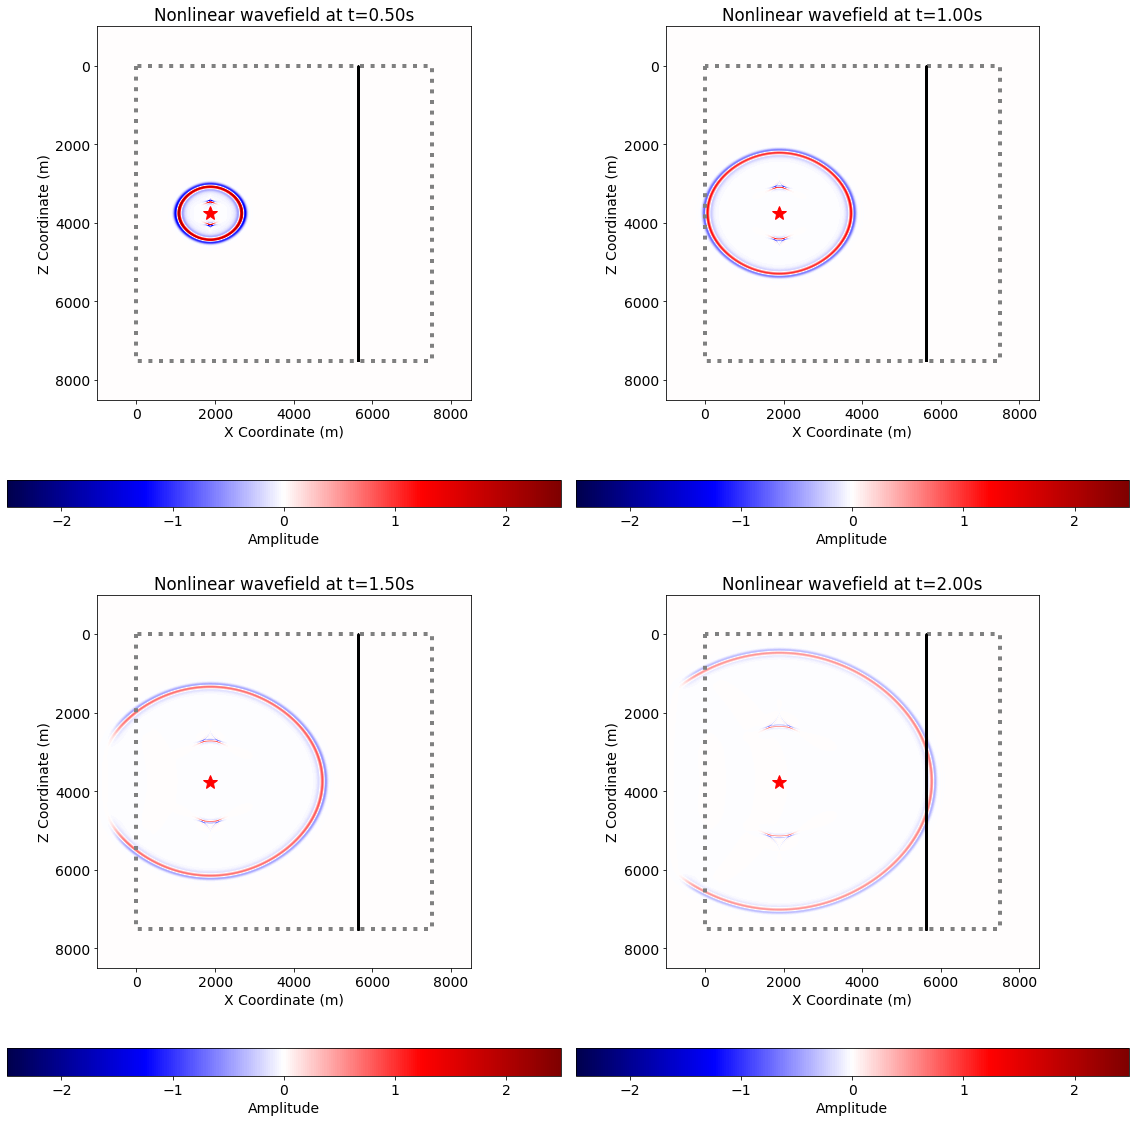

In [27]:
#NBVAL_INGNORE_OUTPUT

# Plot the two wavefields, each normalized to own maximum
kt1 = int( 500 / dt) + 1
kt2 = int(1000 / dt) + 1
kt3 = int(1500 / dt) + 1
kt4 = int(2000 / dt) + 1

amax_nl = 0.1 * np.max(np.abs([pmin, pmax]))
print("amax nl; %12.6f" % (amax_nl))

plt.figure(figsize=(16,16))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(p0.data[kt1,:,:]), cmap="seismic", 
           vmin=-amax_nl, vmax=+amax_nl, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Nonlinear wavefield at t=%.2fs" % (dt * kt1 / 1000))

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(p0.data[kt2,:,:]), cmap="seismic",
           vmin=-amax_nl, vmax=+amax_nl, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Nonlinear wavefield at t=%.2fs" % (dt * kt2 / 1000))

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(p0.data[kt3,:,:]), cmap="seismic",
           vmin=-amax_nl, vmax=+amax_nl, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Nonlinear wavefield at t=%.2fs" % (dt * kt3 / 1000))

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(p0.data[kt4,:,:]), cmap="seismic",
           vmin=-amax_nl, vmax=+amax_nl, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Nonlinear wavefield at t=%.2fs" % (dt * kt4 / 1000))

plt.tight_layout()
None

## Discussion

This concludes the implementation of the nonlinear forward operator. This series continues in the next notebook that describes the implementation of the Jacobian linearized forward and adjoint operators.

[ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)


<a id="refs"></a>
## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
